## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
save = True
save_space = True

## Step 1: Download OSMnx network (G, nodes and edges)

### Step 1 - Required data - Directories

In [3]:
aoi_dir = "../../data/external/prox_latam/aoi_ags.gpkg"
nodes_save_dir = '../../data/external/temporal_fromjupyter/01_nodes_concat.gpkg'
edges_save_dir = '../../data/external/temporal_fromjupyter/01_edges_concat.gpkg'

### Step 1 - Required data - Area of Interest

<Axes: >

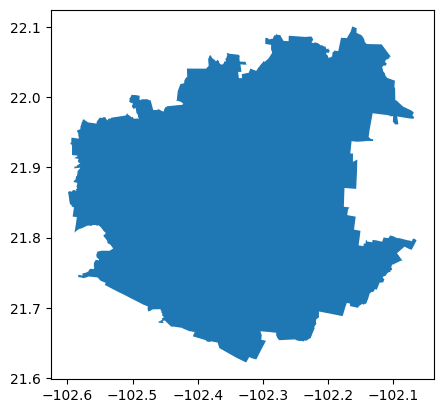

In [4]:
aoi = gpd.read_file(aoi_dir)

#Show
aoi.plot()

### Step 1: Code

In [5]:
def download_osmnx(aoi, save_space = True):
    #Read area of interest as a polygon
    poly = aoi.geometry

    # Extracts coordinates from polygon as DataFrame
    coord_val = poly.bounds

    # Gets coordinates for bounding box
    n = coord_val.maxy.max()
    s = coord_val.miny.min()
    e = coord_val.maxx.max()
    w = coord_val.minx.min()

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Extracted min and max coordinates from the municipality. Polygon N:{round(n,5)}, S:{round(s,5)}, E{round(e,5)}, W{round(w,5)}.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    # Downloads OSMnx graph from bounding box
    G = ox.graph_from_bbox(n, s, e, w, network_type="all_private")

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Downloaded data from OSMnx.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    #Transforms graph to nodes and edges Geodataframe
    nodes, edges = ox.graph_to_gdfs(G)

    #Resets index to access osmid as a column
    nodes.reset_index(inplace=True)

    #Resets index to acces u and v as columns
    edges.reset_index(inplace=True)

    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Converted OSMnx graph to {len(nodes)} nodes and {len(edges)} edges GeoDataFrame.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

    # Defines columns of interest for nodes and edges
    nodes_columns = ["osmid", "x", "y", "street_count", "geometry"]
    edges_columns = [
        "osmid",
        "v",
        "u",
        "key",
        "oneway",
        "lanes",
        "name",
        "highway",
        "maxspeed",
        "length",
        "geometry",
        "bridge",
        "ref",
        "junction",
        "tunnel",
        "access",
        "width",
        "service",
    ]

    # if column doesn't exist it creates it as nan
    for c in nodes_columns:
        if c not in nodes.columns:
            nodes[c] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Added column {c} for nodes.")
            #---------------------------------------------------------------------------------------------------------------------------------------------

    for c in edges_columns:
        if c not in edges.columns:
            edges[c] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Added column {c} for edges.")
            #---------------------------------------------------------------------------------------------------------------------------------------------

    # Filters GeoDataFrames for relevant columns
    nodes = nodes[nodes_columns]
    edges = edges[edges_columns]
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Filtered columns.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Converts columns with lists to strings to allow saving to local and further processes.
    for col in nodes.columns:
        if any(isinstance(val, list) for val in nodes[col]):
            nodes[col] = nodes[col].astype('string')
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Column: {col} in nodes gdf, has a list in it, the column data was converted to string.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
    
    for col in edges.columns:
        if any(isinstance(val, list) for val in edges[col]):
            edges[col] = edges[col].astype('string')
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Column: {col} in nodes gdf, has a list in it, the column data was converted to string.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
    
    # Saves space in disk if instructed
    if save_space:
        del nodes_columns
        del edges_columns
        del c
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print("Saved space by deleting used data.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
    
    return G,nodes,edges

In [6]:
G, nodes, edges = download_osmnx(aoi, save_space = save_space)

Extracted min and max coordinates from the municipality. Polygon N:22.10033, S:21.62227, E-102.06451, W-102.59887.
Downloaded data from OSMnx.
Converted OSMnx graph to 60233 nodes and 142263 edges GeoDataFrame.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: ref in nodes gdf, has a list in it, the column data was converted to string.
Saved space by deleting used data.


In [7]:
if save:
    nodes.to_file(nodes_save_dir, driver='GPKG')
    edges.to_file(edges_save_dir, driver='GPKG')

## Step 2: Calculate distance from each poi to nearest node (osmid)

### Step 2 - Required data - Directories

In [8]:
pois_dir = "../../data/external/prox_latam/pois_ags.gpkg"
nearest_save_dir = '../../data/external/temporal_fromjupyter/02_pois_distance_node_concat.gpkg'

### Step 2- Required data - Points of Interest

In [9]:
pois = gpd.read_file(pois_dir)

#Show
print(pois.shape)
pois.head(2)

(20792, 2)


,code,geometry
0,611111,POINT (-102.27464 21.90191)
1,611111,POINT (-102.26601 21.85971)


### Step 2 - Code

In [10]:
# Format to calculate nearest
pois = pois.set_crs("EPSG:4326")
nodes_gdf = nodes.set_crs("EPSG:4326")
edges_gdf = edges.set_crs("EPSG:4326")

nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf = edges_gdf.set_index(["u", "v", "key"])

# Calculate nearest
nearest = aup.find_nearest(G, nodes_gdf, pois, return_distance= True)

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated distances from pois to nearest node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Calculated distances from pois to nearest node.


### Step 2 - Compare data

In [11]:
#Show
print(nearest.shape)
nearest.head(2)

(20792, 4)


,code,geometry,osmid,distance_node
0,611111,POINT (-102.27464 21.90191),961580633,16.377978
1,611111,POINT (-102.26601 21.85971),2253747737,71.553289


In [12]:
nearest.distance_node.sum()

517514.431670162

In [13]:
nearest.osmid.sum()

52307150069060

In [14]:
if save:
    nearest.to_file(nearest_save_dir, driver='GPKG')

## Step 3: Calculate distance to nearest source amenity for each node

### Step 3 - Required data - Directories

In [15]:
nodesproximity_save_dir = '../../data/external/temporal_fromjupyter/03_nodes_proximity_2020_concat.gpkg'

### Step 3 - Required data - Name of area of interest

In [16]:
city = 'Aguascalientes'

### Step 3 - Required data - Source dictionary

In [17]:
sources = { 
    #Preescolar
    'denue_preescolar':[611111, 611112],
    #Primaria
    'denue_primaria':[611121, 611122],
    #Secundaria
    'denue_secundaria':[611131, 611132],
    #Salud
    'clues_primer_nivel':[8610],
    #Guarderías
    'denue_guarderias':[624411, 624412],
    #Asistencia social
    'denue_dif':[931610],
    #Alimentos
    'denue_supermercado':[462111],'denue_abarrotes':[461110], 'denue_carnicerias': [461121, 461122, 461123],'sip_mercado':[4721],
    #Personal       
    'denue_peluqueria':[812110],
    #Farmacias       
    'denue_farmacias':[464111, 464112],
    #Hogar       
    'denue_ferreteria_tlapaleria':[467111],'denue_art_limpieza':[467115],
    #Complementarios
    'denue_ropa':[463211, 463212, 463213, 463215, 463216, 463218],'denue_calzado':[463310], 'denue_muebles':[466111, 466112, 466113, 466114],'denue_lavanderia':[812210],'denue_revistas_periodicos':[465313],'denue_pintura':[467113],
    #Social
    'denue_restaurante_insitu':[722511, 722512, 722513, 722514, 722519],'denue_restaurante_llevar':[722516, 722518, 722517],'denue_bares':[722412],'denue_cafe':[722515],
    #Actividad física       
    'sip_cancha':[93110],'sip_unidad_deportiva':[93111],'sip_espacio_publico':[9321],'denue_parque_natural':[712190],
    #Cultural       
    'denue_cines':[512130],'denue_museos':[712111, 712112]}

### Step 3 - Code

In [18]:
# Format
pois_distance_node = nearest.copy()
edges_gdf['length'].fillna(edges_gdf['length'].mean(),inplace=True)

# ELEMENTS NEEDED OUTSIDE THE LOOP - nodes_analysis is a nodes_gdf out of loop used in aup.calculate_distance_nearest_poi in each loop
nodes_analysis = nodes_gdf.reset_index().copy()
# ELEMENTS NEEDED OUTSIDE THE LOOP - nodes_sources is a nodes_gdf out of loop used to accumulate a final gdf with the minimal distance from each node to each source
nodes_sources = gpd.GeoDataFrame()
# ELEMENTS NEEDED OUTSIDE THE LOOP - Count
i = 0

# Loop that calculates distance from each node to each source (source by source)
for s in sources:
    
    # Locate pois data for current source
    source_gdf = gpd.GeoDataFrame()
    for cod in sources[s]:
        source_tmp = pois_distance_node[pois_distance_node['code']==cod]
        source_gdf = pd.concat([source_gdf,source_tmp])
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Loaded a total of {len(source_gdf)} points of interest of the source {s} for analisis.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Data for current amenity loop - df_temp: Each column will be a batch of procesed nodes.
    df_temp = nodes_gdf.copy()
    # Data for current amenity loop - nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance and finally to nodes_sources (outside loop)
    nodes_distance = nodes_gdf.copy()
    
    # In case there are no amenities of a certain type in the city
    if len(source_gdf) == 0:
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = 0
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"0 points of interest of the source {s} found, time is NaN.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------       
    
    # Elif, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)
    elif len(source_gdf) % 250:
        batch_size = len(source_gdf)/200
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(200*k):int(200*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
        
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated time from nodes to pois for a total of {len(nodes_distance)} nodes for source {s}.")
        #------------------------------------------------------------------------------------------------------------------------------------------------- 

    # Else, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)   
    else:
        batch_size = len(source_gdf)/250
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
    
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated time from nodes to pois for a total of {len(nodes_distance)} nodes for source {s}.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------    
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Applying final formating to calculated nodes.")
    #----------------------------------------------------------------------------------------------------------------------------------------------------- 
    
    #Format nodes_distance
    nodes_time['source'] = s
    nodes_time['city'] = city
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time','source','city','x','y','geometry']]
    
    #If it is the first round nodes_sources is created equal to nodes_distance (all nodes, one source)
    #If it is the second or more, the new nodes_distance is merged.
    #This way we obtain the final gdf of interest that will contain the minimum disstance to each type of amenity by column.
    if i == 0:
        nodes_sources = nodes_time.copy()
    else:
        nodes_sources = pd.concat([nodes_sources,nodes_time])
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Added time for source {s} to nodes_sources.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------        
    
    i += 1

Loaded a total of 306 points of interest of the source denue_preescolar for analisis.
Starting range k = 0 of 1 for source denue_preescolar.
Starting range k = 1 of 1 for source denue_preescolar.
Calculated time from nodes to pois for a total of 60233 nodes for source denue_preescolar.
Applying final formating to calculated nodes.
Added time for source denue_preescolar to nodes_sources.
Loaded a total of 309 points of interest of the source denue_primaria for analisis.
Starting range k = 0 of 1 for source denue_primaria.
Starting range k = 1 of 1 for source denue_primaria.
Calculated time from nodes to pois for a total of 60233 nodes for source denue_primaria.
Applying final formating to calculated nodes.
Added time for source denue_primaria to nodes_sources.
Loaded a total of 70 points of interest of the source denue_secundaria for analisis.
Starting range k = 0 of 0 for source denue_secundaria.
Calculated time from nodes to pois for a total of 60233 nodes for source denue_secundaria.

In [19]:
if save:
    nodes_sources.to_file(nodesproximity_save_dir, driver='GPKG')

In [20]:
schema = 'prox_analysis'
table = 'nodes_proximity_2020'

query = f"SELECT * FROM {schema}.{table} WHERE \"metropolis\" LIKE \'{city}\'"
nodes_prox = aup.gdf_from_query(query, geometry_col='geometry')

summary = pd.DataFrame()
i = 0

for s in sources:
    
    #Old data
    amenity_gdf = nodes_prox.loc[nodes_prox.amenity == s]
    old_mean = amenity_gdf.time.mean()
    
    #New Data
    source_gdf = nodes_sources.loc[nodes_sources.source == s]
    new_mean = source_gdf.time.mean()
    
    summary.loc[i,'source'] = s
    summary.loc[i,'old_mean_data'] = old_mean
    summary.loc[i,'new_mean_data'] = new_mean
    
    i = i + 1
    
summary['diff'] = summary['old_mean_data'] - summary['new_mean_data']
summary

,source,old_mean_data,new_mean_data,diff
0,denue_preescolar,33.837910,55.577241,-21.739330
1,denue_primaria,34.258209,55.841008,-21.582799
2,denue_secundaria,45.826365,66.825726,-20.999361
3,clues_primer_nivel,34.123632,46.424953,-12.301322
4,denue_guarderias,41.959923,63.909352,-21.949428
5,denue_dif,66.038962,89.753966,-23.715004
6,denue_supermercado,62.590882,87.467038,-24.876157
7,denue_abarrotes,26.946920,48.586716,-21.639795
8,denue_carnicerias,35.527392,57.710202,-22.182810
9,sip_mercado,87.941042,114.625426,-26.684384


In [21]:
#Show
print(nodes_prox.shape)
nodes_prox.head(2)

(2208953, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,817349939,-102.303738,21.882370,POINT (-102.30374 21.88237),3.363196,sigade_preescolar,Aguascalientes
1,840674582,-102.315734,21.897341,POINT (-102.31573 21.89734),3.444772,sigade_preescolar,Aguascalientes


## Step 4 - Analize distance data by nodes to proximity in hexagons

### Step 4 - Required data - Resolution of hexgrid output

In [22]:
res_list = [8,9]

### Step 4 - Required data - Proximity parameters and definitions

In [23]:
#--------------- PREPARE DATA ---------- SET PARAMETER DEFINITIONS
    #This step sets the ejes, amenidades, sources and weights for further analysis
    #{Eje (e):
    #         {Amenidad (a):
    #                       {Source (s))}}}
idx_15_min = {'Escuelas':{'Preescolar':['denue_preescolar'],
                          'Primaria':['denue_primaria'],
                          'Secundaria':['denue_secundaria']},
             'Servicios comunitarios':{'Salud':['clues_primer_nivel'],
                                       'Guarderías':['denue_guarderias'],
                                       'Asistencia social':['denue_dif']},
              'Comercio':{'Alimentos':['denue_supermercado','denue_abarrotes',
                                       'denue_carnicerias','sip_mercado'],
                          'Personal':['denue_peluqueria'],
                          'Farmacias':['denue_farmacias'],
                          'Hogar':['denue_ferreteria_tlapaleria','denue_art_limpieza'],
                          'Complementarios':['denue_ropa','denue_calzado','denue_muebles',
                                             'denue_lavanderia','denue_revistas_periodicos',
                                             'denue_pintura']},
              'Entretenimiento':{'Social':['denue_restaurante_insitu','denue_restaurante_llevar',
                                           'denue_bares','denue_cafe'],
                                 'Actividad física':['sip_cancha','sip_unidad_deportiva',
                                                    'sip_espacio_publico','denue_parque_natural'],
                                 'Cultural':['denue_cines','denue_museos']} 
             }

#If weight of amenity is less than number of sources, the algorith chooses the minimum time to source. 
#Else (if equall or greater), the algorithm chooses max time.
wegiht_idx = {'Escuelas':{'Preescolar':1,
                          'Primaria':1,
                          'Secundaria':1},
              'Servicios comunitarios':{'Salud':1,
                                        'Guarderías':1,
                                        'Asistencia social':1},
              'Comercio':{'Alimentos':1, #Will choose min time to source.
                          'Personal':1,
                          'Farmacias':1,
                          'Hogar':1, #Will choose min time to source.
                          'Complementarios':1},  #Will choose min time to source.
              'Entretenimiento':{'Social':4,
                                 'Actividad física':1,  #Will choose min time to source.
                                 'Cultural':1}  #Will choose min time to source.
             }

### Step 4 - Optional data - Directories

In [24]:
# Location of saved data (Required)
proximityanalysis_save_dir = '../../data/external/temporal_fromjupyter/04_proximityanalysis_hexres9_concat.gpkg'

# Location of pop data file (optional)
pop_dir = "../../data/external/prox_latam/pop_gdf_ags.gpkg"

pop_save_dir = '../../data/external/temporal_fromjupyter/04_hex_pop_concat.gpkg'

### Step 4 - Optional data - Population data

In [25]:
pop_output = True

# Insert name of column with pop data (optional)
pop_column = 'pobtot'

# Insert name of pop gdf index column (optional)
pop_index_column = 'cvegeo'

### Step 4 - Code - Pop Data (Optional)

In [26]:
def create_popdata_hexgrid(aoi,pop_dir,pop_column,pop_index_column,res_list):
    
    pop_gdf = gpd.read_file(pop_dir)
    
    # Format and isolate data of interest
    pop_gdf = pop_gdf.to_crs("EPSG:4326")
    pop_gdf.columns = pop_gdf.columns.str.lower()
    block_pop = pop_gdf[[pop_index_column,pop_column,'geometry']]

    # Extract point from polygon
    block_pop = block_pop.to_crs("EPSG:6372")
    block_pop = block_pop.set_index(pop_index_column)
    point_within_polygon = gpd.GeoDataFrame(geometry=block_pop.representative_point())

    # Add census data to points
    centroid_block_pop = point_within_polygon.merge(block_pop, right_index=True, left_index=True) 

    # Format centroid with pop data
    centroid_block_pop.drop(columns=['geometry_y'], inplace=True)
    centroid_block_pop.rename(columns={'geometry_x':'geometry'}, inplace=True)
    centroid_block_pop = gpd.GeoDataFrame(centroid_block_pop, geometry='geometry')
    centroid_block_pop = centroid_block_pop.to_crs("EPSG:4326")
    centroid_block_pop = centroid_block_pop.reset_index()
    centroid_block_pop.rename(columns={pop_column:'pobtot'},inplace=True)

    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Converted to centroids with {centroid_block_pop.pobtot.sum()} " + f"pop vs {block_pop.pobtot.sum()} pop in original gdf.")
    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # create buffer for aoi to include outer blocks when creating hexgrid
    aoi_buffer = aoi.copy()
    aoi_buffer = aoi_buffer.dissolve()
    aoi_buffer = aoi_buffer.to_crs("EPSG:6372").buffer(2500)
    aoi_buffer = gpd.GeoDataFrame(geometry=aoi_buffer)
    aoi_buffer = aoi_buffer.to_crs("EPSG:4326")

    hex_socio_gdf = gpd.GeoDataFrame()

    for res in res_list:
        # Generate hexagon gdf
        hex_gdf = aup.create_hexgrid(aoi_buffer, res)
        hex_gdf = hex_gdf.set_crs("EPSG:4326")

        # Format - Remove res from index name and add column with res
        hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        hex_gdf['res'] = res
        #-----------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Created hex_grid with {res} resolution")
        #-----------------------------------------------------------------------------------------------------------------------------------------------------    
        # Group pop data
        # def socio_points_to_polygon(gdf_polygon,gdf_socio,cve_column,string_columns,wgt_dict=None,avg_column=None):
        # Agruments:
            #gdf_polygon (geopandas.GeoDataFrame): GeoDataFrame polygon where sociodemographic data will be grouped
            #gdf_socio (geopandas.GeoDataFrame): GeoDataFrame points with sociodemographic data
            #cve_column (str): Column name with polygon id in gdf_polygon.
            #string_columns (list): List with column names for string data in gdf_socio.
            #wgt_dict {dict, optional): Dictionary with average column names and weight column names for weighted average. Defaults to None.
            #avg_column (list, optional): List with column names with average data. Defaults to None.

        string_columns = [pop_index_column]
        hex_socio_df = aup.socio_points_to_polygon(hex_gdf, centroid_block_pop,'hex_id', string_columns)

        #-----------------------------------------------------------------------------------------------------------------------------------------------------     
        print(f"Agregated socio data to hex with a total of {hex_socio_df.pobtot.sum()} population for resolution {res}.")
        #----------------------------------------------------------------------------------------------------------------------------------------------------- 

        # Hexagons to GeoDataFrame
        hex_socio_gdf_tmp = hex_gdf.merge(hex_socio_df, on='hex_id')

        hectares = hex_socio_gdf_tmp.to_crs("EPSG:6372").area / 10000
        hex_socio_gdf_tmp['dens_pob_ha'] = hex_socio_gdf_tmp['pobtot'] / hectares

        #-----------------------------------------------------------------------------------------------------------------------------------------------------    
        print(f"Calculated an average density of {hex_socio_gdf_tmp.dens_pob_ha.mean()}")
        #-----------------------------------------------------------------------------------------------------------------------------------------------------

        hex_socio_gdf = pd.concat([hex_socio_gdf,hex_socio_gdf_tmp])    

    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Finished calculating population by hexgrid for res {res_list}.")
    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    
    return hex_socio_gdf

In [27]:
if pop_output:
    hex_socio_gdf = create_popdata_hexgrid(aoi,pop_dir,pop_column,pop_index_column,res_list)
    if save:
        hex_socio_gdf.to_file(pop_save_dir, driver='GPKG')

Converted to centroids with 1043905 pop vs 1043905 pop in original gdf.
Created hex_grid with 8 resolution
Agregated socio data to hex with a total of 1043905.0 population for resolution 8.
Calculated an average density of 39.753067559930635
Created hex_grid with 9 resolution
Agregated socio data to hex with a total of 1043905.0 population for resolution 9.
Calculated an average density of 57.50817597082861
Finished calculating population by hexgrid for res [8, 9].


### Step 4 - Code - Transform nodes data

In [28]:
nodes = nodes_sources.copy()

#--------------- PREPARE DATA
#--------------- PREPARE DATA ---------- DELETE DUPLICATES AND CLEAN NODES
#This step keeps osmid, geometry and metropolis (without duplicates, keeping only one point for each node) to store times to each amenity source by node in following loop.
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','city']].copy()

#--------------- PREPARE DATA ---------- REORGANIZE NODES DATA
#This step organizes data by nodes by changing (time to source amenities) from rows (1 column with source amenity name + 1 column with time data) 
#to columns (1 column with time data named after its source amenity)
nodes_analysis = nodes_geom.copy()

for source_amenity in list(nodes.source.unique()):
    nodes_tmp = nodes.loc[nodes.source == source_amenity,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':source_amenity})
    # Search for amenities that aren't present in the city (with all values marked as 0) and change them to NaN
    if nodes_tmp[source_amenity].mean() == 0:
        nodes_tmp[source_amenity] = np.nan
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')

if save_space:
    del nodes_sources
    del nodes_geom
    del nodes_tmp

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Transformed nodes data.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Transformed nodes data.


In [29]:
#Show
print(nodes_analysis.shape)
nodes_analysis.head(2)

(60233, 33)


,osmid,geometry,city,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_dif,denue_supermercado,...,denue_restaurante_insitu,denue_restaurante_llevar,denue_bares,denue_cafe,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,denue_parque_natural,denue_cines,denue_museos
0,301189389,POINT (-102.34221 21.84854),Aguascalientes,6.400245,6.400245,2.133810,49.969125,5.135355,35.372640,31.292565,...,5.639280,2.802210,38.864595,2.133810,152.447610,79.55634,9.610185,NaN,81.32691,37.025325
1,301189406,POINT (-102.35022 21.85082),Aguascalientes,17.556360,17.556360,14.897805,50.857980,16.302480,46.539765,44.056560,...,16.795395,13.969335,48.043620,14.897805,140.144235,91.38255,20.766300,NaN,89.40900,45.107415


### Step 4 - Code - Fill for missing amenities

In [30]:
#--------------- PREPARE DATA ---------- FILL MISSING COLUMNS (In case there is a source amenity not available in a city)
sources = []

# Gather all possible sources
for eje in idx_15_min.keys():
    for amenity in idx_15_min[eje].values():
        for source in amenity:
            sources.append(source)
            
# If source not in currently analized city, fill column with np.nan
column_list = list(nodes_analysis.columns)
missing_sourceamenities = []

for s in sources:
        if s not in column_list:
            nodes_analysis[s] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"{s} source amenity is not present in {city}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            missing_sourceamenities.append(s)
            
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Finished missing source amenities analysis. {len(missing_sourceamenities)} not present source amenities were added as np.nan columns")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished missing source amenities analysis. 0 not present source amenities were added as np.nan columns


### Step 4 - Code - Amenities analysis

In [31]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Starting proximity to amenities analysis by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------- PROCESS DATA 
#--------------- PROCESS DATA ---------- Max time calculation
#This step calculates times by amenity

column_max_all = [] # list with all max index column names
column_max_ejes = [] # list with ejes index column names

#Goes through each eje in dictionary:
for e in idx_15_min.keys():

    #Appends to 3 lists currently examined eje
    column_max_all.append('max_'+ e.lower())
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes through each amenity of current eje:
    for a in idx_15_min[e].keys():

        #Appends to 2 lists currently examined amenity:
        column_max_all.append('max_'+ a.lower())
        column_max_amenities.append('max_'+ a.lower())

        #Calculates time to currently examined amenity:
        #If weight is less than number of sources of amenity, choose minimum time to sources.
        if wegiht_idx[e][a] < len(idx_15_min[e][a]): 
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].min(axis=1)
        #Else, choose maximum time to sources.
        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[idx_15_min[e][a]].max(axis=1)

    #Calculates time to currently examined eje (max time of its amenities):
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1) 

index_column = 'max_time' # column name for maximum time data

#Add to column_max_all list the attribute 'max_time'
column_max_all.append(index_column)

#Assigns "max_time" the max time for all ejes
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1)     

#Add to column_max_all list the attributes 'osmid' and 'geometry' to filter nodes_analysis with the column_max_all list.
column_max_all.append('osmid')
column_max_all.append('geometry')
nodes_analysis_filter = nodes_analysis[column_max_all].copy()

if save_space:
    del nodes_analysis
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated proximity to amenities data by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Starting proximity to amenities analysis by node.
Calculated proximity to amenities data by node.


### Step 4 - Code - Group by hex (mean data)

In [32]:
hex_idx = gpd.GeoDataFrame()

for res in res_list:
    
    #/////////////////////////////////////////////////////////////////////////// HEXGRID DEPENDS ON POP DATA BEING CALCULATED OR NOT ///////////////////////////////////////////////////////////////////////////
    # If pop_output is true, loads previously created hexgrid with pop data
    if pop_output:
        # Load hexgrid
        hex_pop = hex_socio_gdf.loc[hex_socio_gdf['res'] == res]
        
        #Function group_by_hex_mean requires ID to include resolution
        hex_pop.rename(columns={'hex_id':f'hex_id_{res}'},inplace=True)
        
        # Create hex_tmp
        hex_pop = hex_pop.set_crs("EPSG:4326")
        hex_tmp = hex_pop[[f'hex_id_{res}','geometry']].copy()
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Loaded pop hexgrid of resolution {res}")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        
    # If pop_output is false, creates hexgrid
    else:
        # Create hexgrid (which already has ID_res)
        hexgrid = aup.create_hexgrid(aoi,res)
        
        # Create hex_tmp
        hexgrid = hexgrid.set_crs("EPSG:4326")
        hex_tmp = hexgrid.copy()
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Created hexgrid of resolution {res}")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        
    #/////////////////////////////////////////////////////////////////////////// HEXGRID DEPENDS ON POP DATA BEING CALCULATED OR NOT ///////////////////////////////////////////////////////////////////////////
    
    # group data by hex
    hex_res_idx = aup.group_by_hex_mean(nodes_analysis_filter, hex_tmp, res, index_column)
    hex_res_idx = hex_res_idx.loc[hex_res_idx[index_column]>0].copy()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Grouped nodes data by hexagons res {res}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    #////////////////////////////////////////////////////////////////////////////////// ADD POP DATA IF POP DATA IS CONSIDERED /////////////////////////////////////////////////////////////////////////////////
    # Add pop data
    if pop_output:
        pop_list = [f'hex_id_{res}','pobtot','dens_pob_ha']
        hex_res_pop = pd.merge(hex_res_idx, hex_pop[pop_list], on=f'hex_id_{res}')
    else:
        hex_res_pop = hex_res_idx.copy()
    #////////////////////////////////////////////////////////////////////////////////// ADD POP DATA IF POP DATA IS CONSIDERED /////////////////////////////////////////////////////////////////////////////////    
    
    # After funtion group_by_hex_mean we can remove res from ID and set as a column
    hex_res_pop.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_res_pop['res'] = res

    hex_idx = hex_idx.append(hex_res_pop)
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------    
    print(f"Saved grouped data by hexagons res {res}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
if save_space:
    if pop_output:
        del hex_socio_gdf #pop_output=True
        del hex_pop #pop_output=True
        del hex_tmp
        del hex_res_idx
        del hex_res_pop #pop_output=True

    else:
        del hexgrid #pop_output=False
        del hex_tmp
        del hex_res_idx

Loaded pop hexgrid of resolution 8


/tmp/ipykernel_5389/1860612382.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_pop.rename(columns={'hex_id':f'hex_id_{res}'},inplace=True)
/tmp/ipykernel_5389/1860612382.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_pop.rename(columns={'hex_id':f'hex_id_{res}'},inplace=True)


Grouped nodes data by hexagons res 8
Saved grouped data by hexagons res 8
Loaded pop hexgrid of resolution 9
Grouped nodes data by hexagons res 9
Saved grouped data by hexagons res 9


### Step 4 - Code - Relculate ejes max times by hexagon

In [33]:
#--------------- PROCESS DATA ---------- RE-CALCULATE MAX TIMES BY HEXAGON (ALL)
# This step recalculates max time to each eje from max times to calculated amenities and max_time from max eje
column_max_ejes = [] # list with ejes index column names

#Goes (again) through each eje in dictionary:
for e in idx_15_min.keys():

    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes (again) through each amenity of current eje:    
    for a in idx_15_min[e].keys():

        column_max_amenities.append('max_'+ a.lower())

    #Re-calculates time to currently examined eje (max time of its amenities):        
    hex_idx['max_'+ e.lower()] = hex_idx[column_max_amenities].max(axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished recalculating times in hexagons')
#-----------------------------------------------------------------------------------------------------------------------------------------------------   

Finished recalculating times in hexagons


### Step 4 - Code - Calculate index and add aditional data

In [34]:
#--------------- PROCESS DATA ---------- INDEX, MEDIAN AND MEAN CALCULATION (ALL)

#Define function
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

#Apply function to amenities columns without ejes ---------------------------------------------///// En lugar de pasarle la lista de amenidades, se crea la lista de amenidades desde column_max_all
max_amenities_cols = [i for i in column_max_all if i not in column_max_ejes]
max_amenities_cols.remove('max_time')
max_amenities_cols.remove('osmid')
max_amenities_cols.remove('geometry')

idx_amenities_cols = [] # list with idx amenity column names
for ac in max_amenities_cols:
    idx_col = ac.replace('max','idx')
    hex_idx[idx_col] = hex_idx[ac].apply(apply_sigmoidal)
    idx_amenities_cols.append(idx_col)

# Add final data
hex_idx[index_column] = hex_idx[column_max_ejes].max(axis=1)
hex_idx['mean_time'] = hex_idx[max_amenities_cols].mean(axis=1)
hex_idx['median_time'] = hex_idx[max_amenities_cols].median(axis=1)
hex_idx['idx_sum'] = hex_idx[idx_amenities_cols].sum(axis=1)
hex_idx['city'] = city
#-----------------------------------------------------------------------------------------------------------------------------------------------------    
print('Finished calculating index, mean and median time')
#-----------------------------------------------------------------------------------------------------------------------------------------------------

Finished calculating index, mean and median time


### Step 4 - Code - Final format

In [35]:
#--------------- FINAL FORMAT ----------
#--------------- FINAL FORMAT ---------- REORDER COLUMNS

# First elements of ordered list - ID and geometry
first_elements = ['hex_id','res','geometry']

# Second elements of ordered list - max_ejes and max_amenities removing max_time, osmid and geometry.
column_max_ejes_amenities = column_max_all.copy()
column_max_ejes_amenities.remove('max_time')
column_max_ejes_amenities.remove('osmid')
column_max_ejes_amenities.remove('geometry')

# Third elements of ordered list are listed in idx_amenities_cols

# Fourth elements of ordered list - Mean, median, max and idx
fourth_elements = ['mean_time', 'median_time', 'max_time', 'idx_sum']

# Fifth elements - If pop is calculated - Pop data
fifth_elements = ['pobtot', 'dens_pob_ha']

# Last element - City data
last_element = ['city']

if pop_output:
    final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + fifth_elements + last_element
else:
    final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + last_element
    
hex_idx_city = hex_idx[final_column_ordered_list]

if save_space:
    del hex_idx
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished final format')
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished final format


In [36]:
if save:
    hex_idx_city.to_file(proximityanalysis_save_dir, driver='GPKG')

### Used to compare data using graph_from_hippo vs using graph from osmnx

In [ ]:
#datos = column_max_ejes_amenities + idx_amenities_cols + fourth_elements + fifth_elements
#datos

#summarydata = pd.DataFrame()

#i = 0

#for c in datos:
#    suma = hex_idx_city[c].mean()
#    summarydata.loc[i,'columna'] = c
#    summarydata.loc[i,'data'] = suma
#    i = i+1
    
#summarydata